A.S. Lundervold, v.04.04.24

> **UNDER CONSTRUCTION**

# Introduction

Deep neural networks are effective at identifying complex patterns in data. They do this by building layers of data representation that are specific to the task they're designed for.

<img src="https://github.com/HVL-ML/DAT255/blob/main/nbs/assets/VGG_neural_network.png?raw=true">

It's possible to take out these layers of representation. We can do this by accessing the activations in the layers of the network. Once we have these representations, we can use them to improve other machine learning models by adding them as features.

In this notebook, we will do just that. We'll extract features from the final hidden layer of a trained convolutional neural network (CNN) and use these features, along with others, to train a new classifier.

To extract these features, we will use a technique called "hooks" in PyTorch, which we have encountered in previous notebooks when we worked on creating class activation maps (CAMs).

**The data**

We'll be working with a collection of histology images from brain tumors for our analysis. Such images reflect the underlying molecular processes and disease progression, and can be used to derive predictive insights into patient outcomes. This dataset has been previously compiled and analyzed in the following studies, which will guide our approach:

* Mobadersany et al. introduced this dataset in their work on using convolutional networks for predicting cancer outcomes from histology and genomics. Their research shows how deep learning can predict patient survival by analyzing histology images alongside genomic data. Their findings are documented in the Proceedings of the National Academy of Sciences (2018). [Read the paper here](https://www.pnas.org/content/pnas/115/13/E2970.full.pdf).

* R. J. Chen et al. further explored this dataset, integrating histopathology and genomic features for cancer diagnosis and prognosis. They introduce a method that combines histology images with genomic information for better survival predictions. By integrating different data types, they achieve more accurate prognoses than when using either data type alone. Their research was published in IEEE Transactions on Medical Imaging, April 2022. [Access their research here](http://doi.org/10.1109/TMI.2020.3021387).

# Setup

In [14]:
# This is a quick check of whether the notebook is currently running on Kaggle, 
# as that makes some difference for the code below.
# We'll do this in every notebook of the course.
import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [15]:
if kaggle:
    !pip install -Uqq fastai

In [16]:
%matplotlib inline
from pathlib import Path
from fastai.vision.all import *

In [17]:
# Sample data set
# Set this to True if you want to use a sample data set.
# Note that using the sample data will significantly reduce the model's performance.

if kaggle:
    sample = True
else:
    sample = False

In [18]:
NB_DIR = Path.cwd()
if sample:
    DATA = Path.home()/'data'/'dat255'/'TCGA-images-sample'
else:
    DATA = Path.home()/'data'/'dat255'/'TCGA-images'
DATA.mkdir(parents=True, exist_ok=True)

# Downloading the data

Depending on whether you're using the sample dataset or the full dataset, this step might take some time. The full dataset is approximately 3.8 GB.

In [19]:
if not sample:
    imgdataurl = 'https://www.dropbox.com/s/jka111c16q8cn6x/PNAS-images.zip?dl=1'
    dataurl = 'https://www.dropbox.com/s/zogil8mxr2p9ajy/pathfusion.zip?dl=1'

elif sample:
    imgdataurl = 'https://www.dropbox.com/scl/fi/sgbq6g0ee0tv883cxic3s/PNAS-images_sample.zip?rlkey=0mi6ssa6tozjuymys7vqk6pt5&dl=1'
    dataurl = 'https://www.dropbox.com/scl/fi/k0homftq297barehs7xpb/pathfusion_sample.zip?rlkey=xaatvgie6tn8iqx6lt51ja07a&dl=1'

else:
    raise ValueError('sample variable must be either True or False')

In [20]:
# Download the image data
if not os.path.isfile(DATA/'PNAS-images.zip'):
    urllib.request.urlretrieve(imgdataurl, DATA/'PNAS-images.zip')

In [21]:
# Extract the image data
if not os.path.isdir(DATA/'images'):
    shutil.unpack_archive(DATA/'PNAS-images.zip', DATA/'images')


In [22]:
# Download and extract the metadata
if not os.path.isfile(DATA/'pathfusion.zip'):
    urllib.request.urlretrieve(dataurl, DATA/'pathfusion.zip')
    if not os.path.isfile(DATA/'metadata'):
        shutil.unpack_archive(DATA/'pathfusion.zip', DATA/'metadata')

In [23]:
# Delete all the zip files in the DATA directory
delete_zips = False

if delete_zips:
    for file in os.listdir(DATA):
        if file.endswith('.zip'):
            os.remove(DATA/file)

# Inspect the data

In [24]:
DATA.ls()

(#4) [Path('/home/alex/data/dat255/TCGA-images/pathfusion.zip'),Path('/home/alex/data/dat255/TCGA-images/images'),Path('/home/alex/data/dat255/TCGA-images/metadata'),Path('/home/alex/data/dat255/TCGA-images/PNAS-images.zip')]

We've stored the images in `DATA/'images'` and the other information in `DATA/'metadata'`.

In [25]:
(DATA/'images').ls()

(#1506) [Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HT-7608-01Z-00-DX6.90E11B10-2543-4534-8523-F15EA688C729_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-19-5951-01Z-00-DX1.a0b16abe-6c89-4fc1-95c5-56757360896b_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HT-7482-01Z-00-DX1.A56F0B29-767B-48C6-A522-7A94F868889B_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-06-0744-01Z-00-DX1.948cea15-dbea-483c-becb-78166086ec0a_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HT-7608-01Z-00-DX3.67EA3645-3674-453C-9AD7-46A2EA060905_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-DH-A66B-01Z-00-DX1.8669A577-0481-4C15-B4CB-0266E154DEFD_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-HT-7875-01Z-00-DX1.5B9314A0-5FA4-4740-A437-01B6380C1262_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-FG-A713-01Z-00-DX1.92B1CBC8-BF31-4748-92B6-EA4ACB3366FF_1.png'),Path('/home/alex/data/dat255/TCGA-images/images/TCGA-12

In [26]:
(DATA/'metadata').ls()

(#6) [Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_100rnaseq_cv_splits_img.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_000_cv_splits_clean.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_000_cv_splits_img.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_000_cv_splits.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_000_cv_splits_activations.csv'),Path('/home/alex/data/dat255/TCGA-images/metadata/tmidata_100rnaseq_cv_splits.csv')]

Let's take a look at some of the metadata:

In [27]:
tmidata_1 = pd.read_csv(DATA/'metadata'/'tmidata_000_cv_splits_img.csv')
tmidata_1.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,imgs,cv_1,cv_2,...,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,0,0,...,0,0,0,1,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,0,0,...,0,0,0,1,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,0,0,...,0,0,0,1,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,...,1,0,0,1,0,1,0,1,0,0
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,...,1,0,0,1,0,1,0,1,0,0


The 'tmidata_000_cv_splits_img.csv' file contains the following information: 

| Feature               | Description                                                                                                                                 |
|-----------------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| `TCGA-ID`             | A unique identifier for each patient sample in [The Cancer Genome Atlas](https://www.cancer.gov/ccg/research/genome-sequencing/tcga), linking clinical, genomic, and histopathology data.                  |
| `Histomolecular subtype` | Classifies tumors based on histological examination and molecular genetics, integrating information like genetic mutations and tissue appearance. |
| `Histology`           | Categorizes the microscopic anatomy of tumor tissues, ranging from cellular morphology to tissue organization, on a numerical scale.         |
| `Grade`               | Indicates the tumor's deviation from normal tissue and aggressiveness, with higher values suggesting more aggressive or poorly differentiated tumors. |
| `Molecular subtype`   | Represents specific genetic expressions or mutations relevant to the cancer's behavior, encoded as numerical values.                        |
| `censored`            | Binary indicator of whether the observation is censored ('1') or uncensored ('0'), essential for survival analysis.                         |
| `Survival months`     | Quantifies the time, in months, a patient has survived following their diagnosis or the start of the study.                                 |
| `imgs`                | Refers to filenames of digitized histology slide images, linking visual data to specific patient samples for model training.                |



In addition, the file contains information about the cross-validation splits used in the original paper.


In [28]:
pd.set_option('display.max_columns', None)

tmidata_2 = pd.read_csv(DATA/'metadata'/'tmidata_000_cv_splits.csv')
tmidata_2.head()

,TCGA ID,Histomolecular subtype,Histology,Grade,Molecular subtype,censored,Survival months,codeletion,idh mutation,EGFR,MDM4,MYC,BRAF,EZH2,MET,SMO,KIAA1549,CREB3L2,NTRK1,PRCC,BLM,NTRK3,CRTC3,CDKN2A,CDKN2B,FGFR2,TSHR,TCL1A,TRIP11,GOLGA5,GPHN,DICER1,TCL6,EBF1,ITK,RPL22,CDKN2C,LCP1,RB1,IRF4,FGFR1OP,MLLT4,MYB,ROS1,TNFAIP3,GOPC,CARD11,JAK2,STK11,PTEN,1q,2p,2q,3p,3q,4p,4q,5p,5q,6p,6q,7p,7q,8p,8q,9p,9q,10p,10q,11p,11q,12p,12q,13q,14q,15q,16p,16q,17p,17q,18p,18q,19p,20p,20q,21q,22q,imgs,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.232,0.296,0.296,0.351,0.351,0.0,0.0,0.0,0.0,0.0,0.0,1.259,1.259,-0.402,-0.402,0.335,0.335,0.000,0.000,-0.132,-0.132,0.335,0.335,0.12,0.0,0.000,0.0,0.0,-0.211,-0.211,0.0,0.0,0.0,-0.133,-0.133,0.591,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.232,0.296,0.296,0.351,0.351,0.0,0.0,0.0,0.0,0.0,0.0,1.259,1.259,-0.402,-0.402,0.335,0.335,0.000,0.000,-0.132,-0.132,0.335,0.335,0.12,0.0,0.000,0.0,0.0,-0.211,-0.211,0.0,0.0,0.0,-0.133,-0.133,0.591,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,2.0,0,1,358,0.0,0.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,0.0,0.232,0.296,0.296,0.351,0.351,0.0,0.0,0.0,0.0,0.0,0.0,1.259,1.259,-0.402,-0.402,0.335,0.335,0.000,0.000,-0.132,-0.132,0.335,0.335,0.12,0.0,0.000,0.0,0.0,-0.211,-0.211,0.0,0.0,0.0,-0.133,-0.133,0.591,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.804,0.804,0.000,0.000,0.000,0.000,-0.866,-0.866,0.000,0.000,0.000,0.000,0.00,0.0,-0.865,0.0,0.0,0.760,0.760,0.0,0.0,0.0,0.000,0.000,0.000,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0
4,TCGA-02-0003,idhwt_ATC,3,2.0,0,1,144,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,0.0,-1.0,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.804,0.804,0.000,0.000,0.000,0.000,-0.866,-0.866,0.000,0.000,0.000,0.000,0.00,0.0,-0.865,0.0,0.0,0.760,0.760,0.0,0.0,0.0,0.000,0.000,0.000,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0


This file contain extensive genetic data about each case. We will use the following two features from this file later in this notebook:

| Feature               | Description                                                                                                                                 |
|-----------------------|-----------------------------------------------------------------------------------------------------------------|
| `codeletion`          | Indicates the presence ('1') or absence ('0') of a simultaneous deletion of genetic material from chromosome arms 1p and 19q, a feature often associated with certain types of brain tumors and their response to therapy. |
| `idh mutation`        | Denotes whether a mutation in the isocitrate dehydrogenase (IDH) gene is present ('1') or absent ('0'), which is significant in the classification and prognosis of various cancers, especially gliomas. |


Later, we'll combine some of the above information with the images to make predictive models. Therefore, let's make a dataframe that includes the image paths and some of the metadata.

> Note that there are multiple images belonging to a single TCGA ID. These are different views on the same tumor. For simplicity, we're going to treat each image as an independent training sample. Note that this is not optimal! The different views may correspond to different grades.

# Prepare the data

In [29]:
columns = [
    'TCGA ID',
     'Histomolecular subtype',
     'Histology',
     'Molecular subtype',
     'codeletion',
     'idh mutation', 
     'imgs', 
     'Grade'
] + [f'cv_{i}' for i in range(1,16)]

In [30]:
df = tmidata_2[columns].copy()

In [31]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0


In [32]:
len(df)

1505

We want to predict the tumor grade from the images (and other features). Let's check for missing labels and also whether the classes are balanced.

In [33]:
df.Grade.value_counts()

Grade
 2.0    654
 1.0    408
 0.0    396
-1.0     47
Name: count, dtype: int64

We note that there is some imbalance, and that some of the labels seem to be missing (i.e., they are `-1.0`). We drop the missing data. 

In [34]:
df.drop(df.loc[df.Grade == -1].index, inplace=True)

In [35]:
df.Grade.value_counts()

Grade
2.0    654
1.0    408
0.0    396
Name: count, dtype: int64

How about missing data in the other features? *

In [36]:
# Check for missing values encoded as NaN values
print("NaN values:")
for col in df.columns[:-15]:
    print(f'{col}: {df[col].isnull().sum()}')
print()

# Check for missing values encoded as -1:
print("-1 values:")
for col in df.columns[:-15]:
    print(f'{col}: {len(df.loc[df[col] == -1])}')


NaN values:
TCGA ID: 0
Histomolecular subtype: 0
Histology: 0
Molecular subtype: 0
codeletion: 0
idh mutation: 0
imgs: 0
Grade: 0

-1 values:
TCGA ID: 0
Histomolecular subtype: 0
Histology: 0
Molecular subtype: 133
codeletion: 0
idh mutation: 0
imgs: 0
Grade: 0


We not that there seems to be some cases with missing data in the `Molecular subtype` feature. Rather than drop these, we'll replace them with the most common value and add an indicator variable for whether the value was missing.

In [37]:
df['Molecular subtype'].value_counts()

Molecular subtype
 0    611
 1    387
 2    327
-1    133
Name: count, dtype: int64

In [38]:
# Add an indicator for the missing values in the 'Molecular subtype' column
df['missing_molecular_subtype'] = df['Molecular subtype'].apply(lambda x: 1 if x == -1 else 0)

# Replace the missing values encoded as -1 with 0 in the 'Molecular subtype' column

df['Molecular subtype'] = df['Molecular subtype'].apply(lambda x: 0 if x == -1 else x)

In [39]:
df['Molecular subtype'].value_counts()

Molecular subtype
0    744
1    387
2    327
Name: count, dtype: int64

In [40]:
df['missing_molecular_subtype'].value_counts()

missing_molecular_subtype
0    1325
1     133
Name: count, dtype: int64

In [41]:
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15,missing_molecular_subtype
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0


In [42]:
df.to_csv(DATA/'metadata'/'tmidata_000_cv_splits_clean.csv', index=False)

# Training an image classifier

## Validation data

We set aside the data from a random selection of TCGA IDs for validation.

> Note: Later, we'll use the cross-validation splits from the original paper to compare our results with theirs.

In [43]:
# Grab a random 20% of the TCGA IDs for validation
np.random.seed(42)
val_ids = np.random.choice(df['TCGA ID'].unique(), size=int(0.2*len(df['TCGA ID'].unique())), replace=False)

print(len(val_ids))
val_ids[:10]

147


array(['TCGA-S9-A6U6', 'TCGA-02-0099', 'TCGA-HT-7676', 'TCGA-12-0691',
       'TCGA-14-1795', 'TCGA-HT-8015', 'TCGA-02-0285', 'TCGA-HT-7686',
       'TCGA-HT-8019', 'TCGA-HT-A616'], dtype=object)

In [44]:
# Mark these as is_valid=True in the dataframe, while the rest is marked as is_valid=False
df['is_valid'] = df['TCGA ID'].apply(lambda x: x in val_ids)
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15,missing_molecular_subtype,is_valid
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,False
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,False
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,False
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,False
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,0,0,False


In [45]:
df.is_valid.value_counts()

is_valid
False    1207
True      251
Name: count, dtype: int64

## Create dataloaders

We create dataloaders with some data augmentation.

In [46]:
bs=32
sz=1024

dls = ImageDataLoaders.from_df(
    df, path=DATA/'images', fn_col='imgs', label_col='Grade', 
    valid_col='is_valid',
    bs=bs,
    item_tfms=None,
    batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), 
                Normalize.from_stats(*imagenet_stats), 
                Resize(sz, method='zeros')])

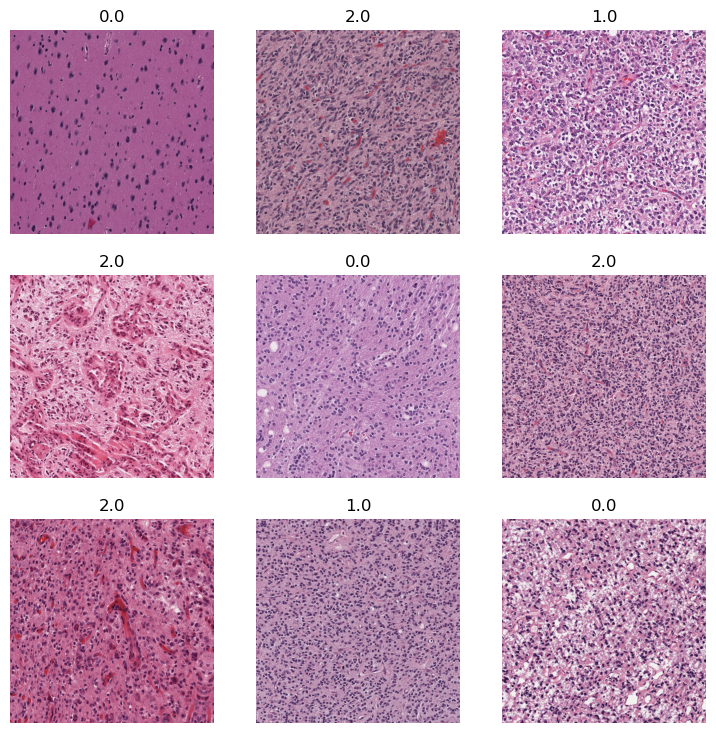

In [47]:
dls.show_batch()

## Create a learner

In [48]:
resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
custom_head = create_head(nf=512, n_out=3, lin_ftrs=[128], concat_pool=True)

In [50]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=3, bias=False)
)

In [51]:
learn = vision_learner(dls, arch=resnet34, 
                       custom_head=custom_head,
                       metrics=[accuracy, RocAuc(), F1Score(average='micro'), 
                                F1Score(average=None)],
                       cbs=[ShowGraphCallback()]).to_fp16()

In [71]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

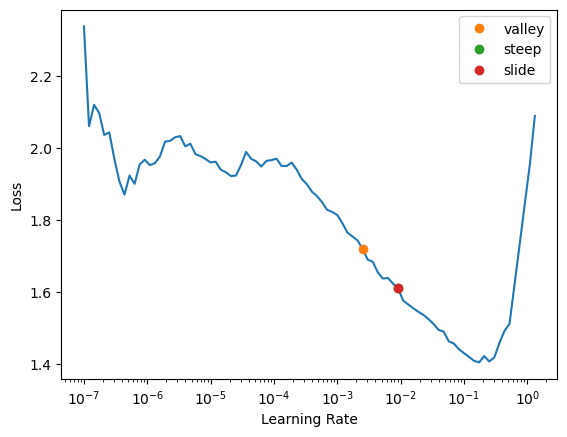

In [53]:
lr = learn.lr_find(suggest_funcs=(valley, steep, slide))

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.098673,1.025836,0.673307,0.840336,0.673307,[0.48484848 0.41071429 0.88372093],00:22
1,0.881068,0.555389,0.749004,0.894263,0.749004,[0.60674157 0.6122449 0.87218045],00:22
2,0.699830,0.492207,0.749004,0.921995,0.749004,[0.57894737 0.5045045 0.91696751],00:22
3,0.601000,0.451847,0.760956,0.913856,0.760956,[0.53191489 0.5942029 0.92592593],00:22
4,0.536115,0.459184,0.764940,0.914850,0.764940,[0.54736842 0.59541985 0.92028986],00:22


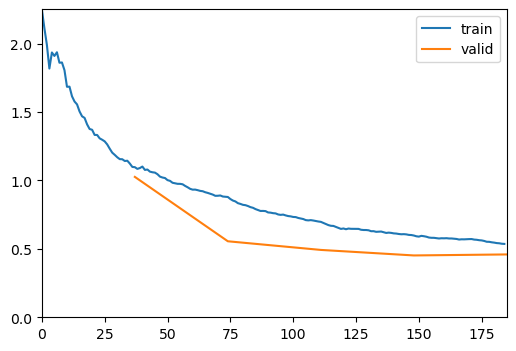

In [54]:
learn.fit_one_cycle(5, lr.slide)

> **Note:** Later, we'll see how we can improve the performance.

# Extracting representations from CNNs

We use PyTorch hooks to extract the output of the last hidden layer of our trained model. This gives us a 128-dimensional representation of each image, which we can use as features in other models.

In [55]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [56]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [57]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

We store the activations in our dataframe

In [58]:
from torchvision import transforms
import torch

to_tensor = transforms.ToTensor()

def process_row(row):
    # Create an image object from the image file path
    img = PILImage.create(DATA/'images'/row['imgs'])
    # Convert the image to a PyTorch tensor
    img = to_tensor(img)
    # Add an extra dimension to the tensor for batch processing
    img = img.unsqueeze(0)
    # Move the tensor to the device where the model is located
    img = img.to(learn.dls.device)
    # Set the model to evaluation mode and get the output of the model
    with torch.no_grad():
        _ = learn.model.eval()(img)
    # Get the activations from the hook_output and move them to the CPU
    activations = hook_output.stored.cpu().numpy()
    # Flatten the activations and return them as a pandas Series
    return pd.Series(activations.flatten())

In [69]:
%%time
# Create a new dataframe where each row is the activations of the corresponding image
activations_df = df.apply(process_row, axis=1)
# Rename the columns of the dataframe to 'activation_i' where i is the index of the activation
activations_df.columns = [f'activation_{i}' for i in range(learn.model[-1][-5].out_features)]

In [70]:
# Join the activations dataframe with the original dataframe
df = df.join(activations_df)

In [ ]:
df.head()

In [ ]:
df.to_csv(DATA/'metadata'/'tmidata_000_cv_splits_activations.csv', index=False)

# Training models on CNN-derived features

In [61]:
df = pd.read_csv(DATA/'metadata'/'tmidata_000_cv_splits_activations.csv')
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,cv_1,cv_2,cv_3,cv_4,cv_5,cv_6,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15,missing_molecular_subtype,is_valid,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,activation_10,activation_11,activation_12,activation_13,activation_14,activation_15,activation_16,activation_17,activation_18,activation_19,activation_20,activation_21,activation_22,activation_23,activation_24,activation_25,activation_26,activation_27,activation_28,activation_29,activation_30,activation_31,activation_32,activation_33,activation_34,activation_35,activation_36,activation_37,activation_38,activation_39,activation_40,activation_41,activation_42,activation_43,activation_44,activation_45,activation_46,activation_47,activation_48,activation_49,activation_50,activation_51,activation_52,activation_53,activation_54,activation_55,activation_56,activation_57,activation_58,activation_59,activation_60,activation_61,activation_62,activation_63,activation_64,activation_65,activation_66,activation_67,activation_68,activation_69,activation_70,activation_71,activation_72,activation_73,activation_74,activation_75,activation_76,activation_77,activation_78,activation_79,activation_80,activation_81,activation_82,activation_83,activation_84,activation_85,activation_86,activation_87,activation_88,activation_89,activation_90,activation_91,activation_92,activation_93,activation_94,activation_95,activation_96,activation_97,activation_98,activation_99,activation_100,activation_101,activation_102,activation_103,activation_104,activation_105,activation_106,activation_107,activation_108,activation_109,activation_110,activation_111,activation_112,activation_113,activation_114,activation_115,activation_116,activation_117,activation_118,activation_119,activation_120,activation_121,activation_122,activation_123,activation_124,activation_125,activation_126,activation_127
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,False,-4.582717,-3.369317,6.862479,-7.954931,1.448599,-1.089071,5.730324,-3.860589,-4.426339,-5.159214,-3.385253,7.265678,7.629381,-2.156606,0.132096,-3.245672,14.938635,6.445856,3.254004,0.115878,13.059584,0.932500,7.903431,6.387709,7.714472,2.709338,-1.186962,4.283219,2.040766,6.245162,-6.861642,6.494898,8.401528,4.266278,-2.649951,2.420448,10.703923,-7.039211,-0.670726,6.779864,10.483406,-3.284508,4.754468,2.782198,-3.626718,-4.723962,2.151880,11.211598,-2.992617,-5.141581,8.615684,-0.099723,6.060158,1.962016,3.830892,0.051370,3.884399,-2.131017,1.322426,1.582219,4.772164,3.741394,-2.844940,4.295528,7.972855,-5.882553,5.603404,7.209235,2.045188,-12.414132,-9.148798,3.517284,7.765364,-15.061008,-3.489476,-0.164492,-5.756180,-4.579787,-6.530701,-5.624476,2.165319,-3.599149,3.436190,-2.951029,16.484587,-1.032720,1.644020,-4.670266,-2.269503,9.727315,1.700099,-9.350258,0.693550,-11.615725,12.692349,2.857479,-5.819820,-4.831585,1.278877,4.031152,-1.049015,2.510707,0.964855,0.519941,0.988255,-11.325369,-10.563420,-8.190792,1.969052,-6.066657,-9.407009,0.354066,-10.335973,8.770063,4.623496,0.193614,-6.427884,0.459710,1.134544,-2.196999,-0.362418,5.192284,0.945829,-0.338882,-5.600298,8.274955,-3.722018,0.081762
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,False,-1.530359,-5.665536,6.379439,-8.301594,-0.209817,-3.165064,6.351608,-4.746036,-4.517259,-4.311618,-0.851931,6.416639,5.563749,-0.937822,1.978869,-3.431338,16.696522,7.609182,3.391707,-0.865593,9.913038,0.394190,4.881143,4.838573,7.203099,3.319838,-0.094289,3.589959,3.584525,7.578918,-6.694353,4.488251,7.813436,3.028972,-2.787561,1.556168,10.645988,-4.894421,-0.632387,6.399627,8.984914,-4.827736,0.863688,3.940450,-2.429952,-8.040915,2.892906,11.922196,-2.504999,-5

Now, we take the CNN-derived features and use them to train a Random Forest classifier. We also explore how combining these features with other available data affects the model's performance.

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def train_rf_model(df, features):
    """
    Train a Random Forest model on specified features and target 'Grade'.
    Automatically handles categorical variables by one-hot encoding.
    
    :param df: DataFrame containing the dataset.
    :param features: List of columns to be used as features.
    :return: Tuple of accuracy, weighted average F1 score, and classification report.
    """
    X = df[features].copy()
    y = df['Grade'].copy()
    X = pd.get_dummies(X, drop_first=True)  # One-hot encode categoricals directly
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = report['accuracy']
    f1_score = report['weighted avg']['f1-score']

    return acc, f1_score, classification_report(y_test, y_pred)



Here are the results:

In [63]:
from prettytable import PrettyTable

activation_columns = df.filter(like='activation_').columns.tolist()
non_activation_columns = [col for col in df.columns if col not in activation_columns + ['TCGA ID', 'Grade', 'imgs', 'is_valid']+[f"cv_{i}" for i in range(1,16)]]
all_columns = [col for col in df.columns if col not in ['TCGA ID', 'Grade', 'imgs', 'is_valid']] + [f"cv_{i}" for i in range(1,16)]

# Define a table to store the results
table = PrettyTable()
table.field_names = ["Title", "Accuracy", "F1 Score"]

# Training on different feature sets
for title, features in [("Training without activations", non_activation_columns),
                        ("Training with activations only", activation_columns),
                        ("Training with activations + other features", all_columns)]:
    acc, f1, _ = train_rf_model(df, features)
    table.add_row([title, round(acc,3), round(f1,3)])

print(table)

+--------------------------------------------+----------+----------+
|                   Title                    | Accuracy | F1 Score |
+--------------------------------------------+----------+----------+
|        Training without activations        |  0.736   |  0.736   |
|       Training with activations only       |  0.705   |  0.693   |
| Training with activations + other features |  0.832   |  0.832   |
+--------------------------------------------+----------+----------+


> Note that if you're using the sample data, your results when training on the activations will likely be significantly worse than those achieved using the full dataset.

## Note: Using `fastai.tabular`


From Module 5, we know that we can also use the `fastai.tabular` module to train a model on the tabular data. 

In [64]:
from fastai.tabular.all import *

In [65]:
tab_dls = TabularDataLoaders.from_df(df, 
                                y_names="Grade", 
                                y_block=CategoryBlock,
                                cat_names=['Histomolecular subtype', 'Histology', 
                                            'Molecular subtype', 'codeletion', 
                                            'idh mutation', 'missing_molecular_subtype'], 
                                cont_names=[f'activation_{i}' for i in range(128)], 
                                procs=[Categorify, FillMissing, Normalize],
                                splits=RandomSplitter(valid_pct=0.2)(range_of(df)))

In [66]:
tab_dls.show_batch()

,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,missing_molecular_subtype,activation_0,activation_1,activation_2,activation_3,activation_4,activation_5,activation_6,activation_7,activation_8,activation_9,activation_10,activation_11,activation_12,activation_13,activation_14,activation_15,activation_16,activation_17,activation_18,activation_19,activation_20,activation_21,activation_22,activation_23,activation_24,activation_25,activation_26,activation_27,activation_28,activation_29,activation_30,activation_31,activation_32,activation_33,activation_34,activation_35,activation_36,activation_37,activation_38,activation_39,activation_40,activation_41,activation_42,activation_43,activation_44,activation_45,activation_46,activation_47,activation_48,activation_49,activation_50,activation_51,activation_52,activation_53,activation_54,activation_55,activation_56,activation_57,activation_58,activation_59,activation_60,activation_61,activation_62,activation_63,activation_64,activation_65,activation_66,activation_67,activation_68,activation_69,activation_70,activation_71,activation_72,activation_73,activation_74,activation_75,activation_76,activation_77,activation_78,activation_79,activation_80,activation_81,activation_82,activation_83,activation_84,activation_85,activation_86,activation_87,activation_88,activation_89,activation_90,activation_91,activation_92,activation_93,activation_94,activation_95,activation_96,activation_97,activation_98,activation_99,activation_100,activation_101,activation_102,activation_103,activation_104,activation_105,activation_106,activation_107,activation_108,activation_109,activation_110,activation_111,activation_112,activation_113,activation_114,activation_115,activation_116,activation_117,activation_118,activation_119,activation_120,activation_121,activation_122,activation_123,activation_124,activation_125,activation_126,activation_127,Grade
0,ODG,2,2,1.0,1.0,0,2.063758,-2.657667,3.586612,-5.459101,1.870920,-0.744740,6.376730,-4.977892,-2.611426,-3.535923,-1.011783,4.529108,7.531673,0.146112,-4.306001,-0.506698,9.120342,1.148282,1.127404,-8.415626,7.833755,-0.189095,3.230483,6.836242,-0.167464,1.560881,4.405776,-2.951159,5.035710,6.779587,-8.302172,5.076405,3.414993,5.155792,0.142347,-1.633455,4.238485,4.269707,2.460529,4.777525,4.876540,-3.960485,-0.190596,-1.903875,-9.214684,0.928093,-0.152800,8.591951,-5.950945,-0.944588,6.215308,2.387498,8.217700,-3.251882,2.240482,4.453847,6.093818,-0.229221,-0.095783,-0.463352,1.831843,4.363296,-0.368643,-0.874503,10.119148,-0.787417,3.057103,1.547319,4.787561,-13.499555,-1.257791,9.976027,1.301912,-17.465900,1.498606,2.142178,-3.999370,-0.444429,-7.759372,-4.042859,4.051015,-8.504606,2.111379,3.743181,9.138506,2.074152,6.741527,-6.505007,-5.252392,6.983360,2.217182,-9.335852,1.809578,-9.107063,12.699677,2.056553,-5.239484,-4.992602,2.078018,3.217550,2.457381,-2.003525,5.954051,-2.034139,-1.755729,-9.504198,-9.420033,-5.359024,-2.177658,-9.905458,-5.148511,-3.015236,-10.796242,5.372881,7.672553,-1.504642,-5.396886,1.577686,0.676884,0.529774,-5.615748,-1.499461,-2.416176,3.515475,-6.117177,5.514492,1.913714,-2.631695,1.0
1,1.0,0,0,0.0,1.0,1,-1.680939,-4.766639,4.887435,-0.769930,6.750838,-5.699649,3.078589,-4.125765,-3.250469,-7.418753,0.060519,10.704575,6.715305,3.816688,2.403480,-3.082509,13.868483,-0.516919,2.843837,-4.331384,15.878572,2.687922,1.526694,7.470772,-0.208165,6.465163,0.680018,1.463805,5.610487,2.548759,-10.999517,9.567630,9.387774,4.357522,3.905192,7.577362,5.266961,-6.090115,-5.252489,2.372265,4.880624,-7.165903,7.965848,-2.460797,-6.080258,-1.246757,-4.979752,18.944862,-6.717269,-4.237021,7.026062,1.580556,8.231351,2.476446,4.374741,-3.261305,5.943855,-0.267811,-0.336944,-0.604053,2.240602,-2.410250,-5.936165,2.741483,6.651708,0.089097,4.465299,3.906242,6.729410,-17.341049,-10.283569,4.718094,5.675653,-17.155529,-5.299180,-6.430243,-6.727933,-6.419532,-9.523912,-7.110883,3.725764,-4.507583,2.107313,-2.752340,15.372848,-0.70715

In [67]:
tab_learn = tabular_learner(tab_dls, metrics=[accuracy, RocAuc(), F1Score(average='micro'), 
                                F1Score(average=None)],)

In [68]:
tab_learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.026179,0.803326,0.663230,0.821419,0.663230,[0.63276836 0.4 0.82264151],00:00
1,0.802648,0.672993,0.690722,0.858067,0.690722,[0.66666667 0.4028777 0.85501859],00:00
2,0.678741,0.630934,0.707904,0.865549,0.707904,[0.63030303 0.47619048 0.88148148],00:00
3,0.584975,0.608908,0.718213,0.877247,0.718213,[0.68571429 0.44927536 0.87732342],00:00
4,0.524490,0.605596,0.721649,0.878664,0.721649,[0.68181818 0.45255474 0.88475836],00:00


> **Your turn!** Try improving the above results by using what you learned in Module 5.

# Extra: improving our image classifier

Note that to compare our grade prediction results with those of reference [1], we need to use the same validation setup as them. We can achieve this by training and evaluating our model 15 times on the 15 different cross validation folds determined by [1] and [2].

In [6]:
df = pd.read_csv(DATA/'metadata'/'tmidata_000_cv_splits_clean.csv')
df.head()

,TCGA ID,Histomolecular subtype,Histology,Molecular subtype,codeletion,idh mutation,imgs,Grade,cv_1,cv_2,...,cv_7,cv_8,cv_9,cv_10,cv_11,cv_12,cv_13,cv_14,cv_15,missing_molecular_subtype
0,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX2.b521a862-280c-4251-ab54-5636f20605d0_1.png,2.0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX3.2836ce55-491f-4d86-99b1-668946927af8_1.png,2.0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,TCGA-02-0001,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0001-01Z-00-DX1.83fce43e-42ac-4dcd-b156-2908e75f2e47_1.png,2.0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX3.995C2924-E298-4517-82A4-15806766CE31_1.png,2.0,0,0,...,0,0,1,0,1,0,1,0,0,0
4,TCGA-02-0003,idhwt_ATC,3,0,0.0,0.0,TCGA-02-0003-01Z-00-DX2.c7652d8d-d78f-49ae-8259-bb2bdb5d50fb_1.png,2.0,0,0,...,0,0,1,0,1,0,1,0,0,0


## Progressive resizing

By first training on a small version of the images and then progressively on larger and larger images one can often improve performance. This is the idea behind **progressive resizing**. In a sense you're pretraining the model on data that's very similar, yet different, to the target data set.

In [7]:
def get_dataloaders(df, sz, bs, cv_col=1):

    if sz*1.2 <= 1024:
        presz = sz*1.2
    else:
        presz = sz
    
    dls = ImageDataLoaders.from_df(
            df, path=DATA/'images', fn_col='imgs', label_col='Grade', 
            valid_col=f'cv_{cv_col}',
            bs=bs,
            item_tfms=Resize(int(presz)),
            batch_tfms=[Contrast(), Dihedral(), Brightness(), Rotate(max_deg=45), 
                        Normalize.from_stats(*imagenet_stats), 
                        Resize(sz, method='zeros')])

    return dls

In [24]:
dls = get_dataloaders(df, 128, 128, 1)

In [25]:
learn = vision_learner(dls, arch=resnet18, 
                       metrics=[accuracy, RocAuc(), F1Score(average='micro'), 
                                F1Score(average=None)],
                       cbs=[ShowGraphCallback()]).to_fp16()

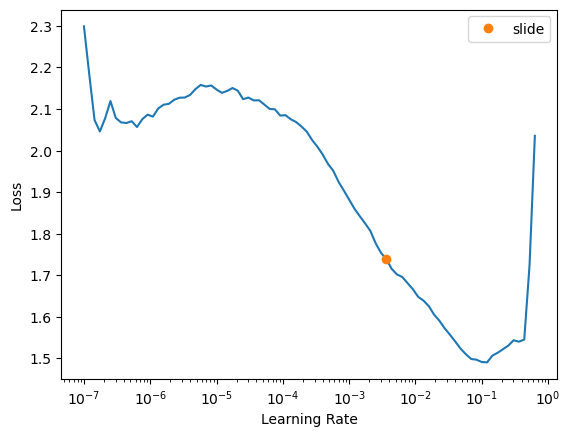

In [20]:
lr = learn.lr_find(suggest_funcs=(slide))

In [21]:
lr.slide

0.00363078061491251

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.518206,0.920023,0.665354,0.829514,0.665354,[0.50877193 0.3030303 0.84745763],00:18
1,1.284791,0.862523,0.688976,0.834326,0.688976,[0.49438202 0.52 0.84758364],00:18
2,1.147508,0.809128,0.692913,0.848571,0.692913,[0.56603774 0.48175182 0.85283019],00:19


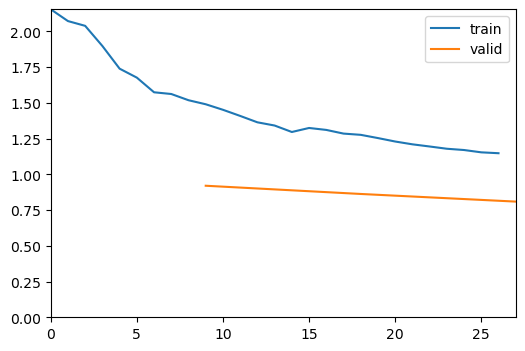

In [26]:
learn.fit_one_cycle(3, lr.slide)

In [27]:
#learn.dls = get_dataloaders(df, 512, 64, 1)
#learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.483655,0.856954,0.665354,0.829680,0.665354,[0.49180328 0.38983051 0.86567164],00:18


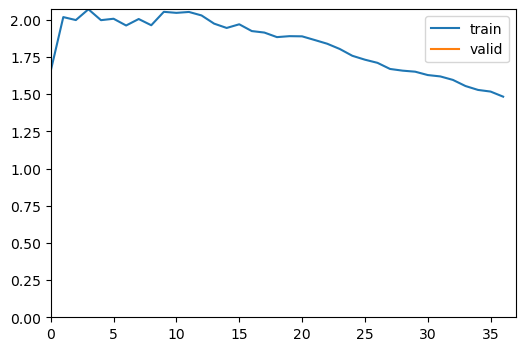

epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.915915,0.665631,0.720472,0.865894,0.720472,[0.52727273 0.52631579 0.89811321],00:20
1,0.833913,0.613763,0.744094,0.883915,0.744094,[0.40963855 0.6122449 0.91366906],00:20
2,0.722460,0.537933,0.791339,0.905051,0.791339,[0.52173913 0.67142857 0.94202899],00:20
3,0.652606,0.522080,0.787402,0.904145,0.787402,[0.56521739 0.64788732 0.93430657],00:20
4,0.612792,0.527372,0.791339,0.905189,0.791339,[0.53932584 0.65714286 0.9390681 ],00:20


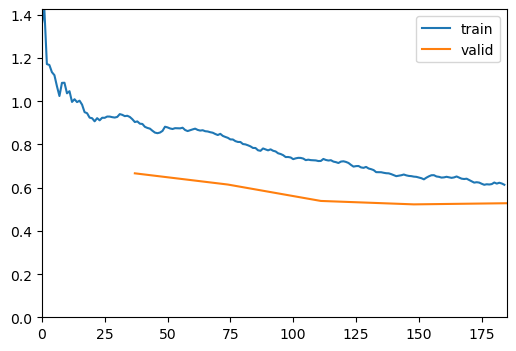

In [28]:
learn.dls = get_dataloaders(df, 1024, 32, 1)
learn.fine_tune(5, 1e-3)

## TTA: Test-time augmentation

In [8]:
from sklearn.metrics import f1_score

In [30]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.7992125749588013

In [31]:
RocAuc()(preds, targs)

0.9079515107099866

In [49]:
f1_score([np.argmax(p) for p in preds], targs, average="micro")

0.7992125984251969

In [50]:
f1_score([np.argmax(p) for p in preds], targs, average=None)

array([0.53488372, 0.66666667, 0.94661922])

## Cross-validation

In [9]:
import gc

In [10]:
def train_model(df,cv_fold):

    # progressive resizing

    dls = get_dataloaders(df, 128, 128, cv_fold)

    learn = vision_learner(dls, arch=resnet18, 
                       metrics=[accuracy, RocAuc(), F1Score(average='micro'), 
                                F1Score(average=None)]).to_fp16()
    print("#"*40)
    print("Finding an initial learning rate...")
    print("#"*40)
    lr = learn.lr_find(suggest_funcs=(slide), show_plot=False)
    print(f"Using learning rate {lr.slide}")

    print("#"*40)
    print("Training model on size 128...")
    print("#"*40)
    learn.fit_one_cycle(3, lr.slide)

    print("#"*40)
    print("Finetuning model on size 1024")
    print("#"*40)
    learn.dls = get_dataloaders(df, 1024, 32, cv_fold)
    learn.fine_tune(7, 1e-3)

    # TTA
    print("#"*40)
    print("Running TTA...")
    print("#"*40)
    preds,targs = learn.tta()

    acc = accuracy(preds, targs).item()
    rocauc = RocAuc()(preds, targs)
    f1_micro = f1_score([np.argmax(p) for p in preds], targs, average="micro")
    f1 = f1_score([np.argmax(p) for p in preds], targs, average=None)
    
    metrics = [acc, rocauc, f1_micro, f1]

    print("#"*40)
    print(
        f"Accuracy: {metrics[0]}. ROCAUC: {metrics[1]}", 
        f"F1 score: {metrics[2]}, F1 score grade IV: {metrics[3][-1]}"
        )
    
    # Free up GPU memory after training
    learn = None
    dls = None
    gc.collect()
    torch.cuda.empty_cache()
    
    return metrics

In [11]:
%%time
cv_metrics = {}
for cv_iter in range(1,16):
    print(f"Crossval iteration {cv_iter}")
    metrics = train_model(df, cv_iter)
    cv_metrics[cv_iter] = metrics
    print("#"*40)
    print()


Crossval iteration 1
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.463258,0.911519,0.657480,0.832009,0.657480,[0.46666667 0.5 0.82307692],00:18
1,1.302781,1.185234,0.559055,0.790426,0.559055,[0.18421053 0.5437788 0.70697674],00:19
2,1.169303,0.843743,0.637795,0.824971,0.637795,[0.31818182 0.51977401 0.83950617],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.305845,0.760716,0.708661,0.838748,0.708661,[0.50943396 0.51612903 0.8705036 ],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.955944,0.668508,0.755906,0.869312,0.755906,[0.56565657 0.6 0.9070632 ],00:20
1,0.816456,0.702397,0.732283,0.870042,0.732283,[0.48888889 0.512 0.90102389],00:19
2,0.728281,0.605431,0.779528,0.894056,0.779528,[0.54166667 0.625 0.92957746],00:20
3,0.649007,0.596188,0.759843,0.886066,0.759843,[0.41463415 0.625 0.92907801],00:20
4,0.583663,0.546335,0.767717,0.897872,0.767717,[0.5631068 0.60606061 0.92307692],00:20
5,0.532080,0.524491,0.803150,0.903051,0.803150,[0.56521739 0.69064748 0.93862816],00:20
6,0.502965,0.540304,0.787402,0.901703,0.787402,[0.53763441 0.66666667 0.93140794],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7755905389785767. ROCAUC: 0.9036640198330739 F1 score: 0.7755905511811023, F1 score grade IV: 0.9285714285714285
########################################

Crossval iteration 2
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.469428,1.495709,0.488673,0.712761,0.488673,[0.46258503 0.29473684 0.63345196],00:19
1,1.304317,1.905029,0.436893,0.702617,0.436893,[0.47761194 0.10169492 0.56034483],00:19
2,1.144851,0.868037,0.624595,0.828052,0.624595,[0.54166667 0.47619048 0.76491228],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.261797,0.784426,0.695793,0.822857,0.695793,[0.56578947 0.46575342 0.8625 ],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.819829,0.673015,0.702265,0.862052,0.702265,[0.49230769 0.47682119 0.884273 ],00:19
1,0.773636,0.717536,0.711974,0.877305,0.711974,[0.45454545 0.51612903 0.87818697],00:19
2,0.656618,0.598806,0.744337,0.885493,0.744337,[0.58571429 0.52348993 0.9118541 ],00:19
3,0.613212,0.572893,0.760518,0.891450,0.760518,[0.61111111 0.51748252 0.9305136 ],00:19
4,0.544668,0.530870,0.773463,0.897555,0.773463,[0.63888889 0.56578947 0.93167702],00:19
5,0.485709,0.534109,0.779935,0.897723,0.779935,[0.66206897 0.57718121 0.92592593],00:19
6,0.463677,0.525232,0.770227,0.900989,0.770227,[0.64788732 0.55263158 0.92592593],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7799353003501892. ROCAUC: 0.9025068221442628 F1 score: 0.7799352750809061, F1 score grade IV: 0.9184290030211479
########################################

Crossval iteration 3
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.564035,1.463096,0.637821,0.795000,0.637821,[0.66326531 0.02272727 0.78235294],00:19
1,1.414100,0.932278,0.650641,0.833693,0.650641,[0.60493827 0.49 0.80152672],00:18
2,1.243523,0.885600,0.685897,0.835632,0.685897,[0.64921466 0.45238095 0.86037736],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.455862,0.743168,0.669872,0.841861,0.669872,[0.62702703 0.4125 0.84587814],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.900509,0.648357,0.721154,0.879015,0.721154,[0.64 0.50617284 0.89198606],00:19
1,0.842437,0.685768,0.721154,0.872329,0.721154,[0.63030303 0.54644809 0.89130435],00:19
2,0.752399,0.657663,0.676282,0.872161,0.676282,[0.47297297 0.53846154 0.89552239],00:19
3,0.674834,0.582476,0.750000,0.896072,0.750000,[0.69945355 0.5398773 0.90647482],00:19
4,0.590447,0.577700,0.775641,0.895510,0.775641,[0.71005917 0.61363636 0.91756272],00:19
5,0.549006,0.576055,0.756410,0.895861,0.756410,[0.71676301 0.55345912 0.89041096],00:19
6,0.511977,0.564286,0.769231,0.897376,0.769231,[0.71264368 0.6 0.90714286],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7467948794364929. ROCAUC: 0.8971260580431927 F1 score: 0.7467948717948718, F1 score grade IV: 0.8982456140350877
########################################

Crossval iteration 4
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.466318,1.112575,0.525490,0.761048,0.525490,[0.51655629 0.29850746 0.66666667],00:19
1,1.245979,1.258560,0.580392,0.803820,0.580392,[0.64935065 0.38926174 0.66666667],00:19
2,1.128150,0.846062,0.635294,0.841125,0.635294,[0.576 0.4137931 0.8 ],00:18


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.336162,0.776220,0.709804,0.854400,0.709804,[0.656 0.43333333 0.86037736],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.905145,0.735391,0.686275,0.867048,0.686275,[0.50943396 0.46715328 0.86891386],00:20
1,0.781906,0.629332,0.752941,0.888523,0.752941,[0.72592593 0.44660194 0.88235294],00:20
2,0.680467,0.599695,0.741176,0.894452,0.741176,[0.73015873 0.49612403 0.87058824],00:20
3,0.610070,0.579588,0.768627,0.900684,0.768627,[0.6984127 0.52542373 0.90977444],00:20
4,0.571199,0.581352,0.760784,0.896184,0.760784,[0.65546218 0.52380952 0.92075472],00:20
5,0.526875,0.594503,0.745098,0.895586,0.745098,[0.6440678 0.50769231 0.90839695],00:20
6,0.484565,0.589007,0.756863,0.897384,0.756863,[0.65517241 0.53435115 0.91254753],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7607843279838562. ROCAUC: 0.9049296221552608 F1 score: 0.7607843137254902, F1 score grade IV: 0.9132075471698113
########################################

Crossval iteration 5
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.538530,1.864797,0.541379,0.756854,0.541379,[0.58823529 0.14035088 0.69298246],00:20
1,1.348430,0.946428,0.658621,0.841931,0.658621,[0.60335196 0.44137931 0.8203125 ],00:19
2,1.163449,0.901089,0.682759,0.850694,0.682759,[0.61290323 0.35087719 0.86428571],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.265609,0.753295,0.675862,0.846507,0.675862,[0.6097561 0.4084507 0.8540146],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.904981,0.599910,0.703448,0.876824,0.703448,[0.65432099 0.43971631 0.86642599],00:19
1,0.833502,0.581723,0.748276,0.887716,0.748276,[0.65 0.53900709 0.91039427],00:19
2,0.721558,0.500509,0.755172,0.905570,0.755172,[0.62025316 0.56953642 0.93726937],00:19
3,0.648294,0.535488,0.737931,0.900695,0.737931,[0.56737589 0.5477707 0.92907801],00:19
4,0.565101,0.474822,0.796552,0.913621,0.796552,[0.67924528 0.64 0.95202952],00:19
5,0.527872,0.469723,0.782759,0.916993,0.782759,[0.68674699 0.57352941 0.94244604],00:19
6,0.487650,0.469665,0.782759,0.916262,0.782759,[0.67901235 0.5915493 0.94202899],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7655172348022461. ROCAUC: 0.9166391399322827 F1 score: 0.7655172413793103, F1 score grade IV: 0.9280575539568345
########################################

Crossval iteration 6
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.458975,1.066753,0.629496,0.795457,0.629496,[0.6 0.31034483 0.8 ],00:19
1,1.267181,0.935687,0.615108,0.812312,0.615108,[0.5443787 0.44186047 0.80930233],00:19
2,1.111309,0.866797,0.654676,0.846589,0.654676,[0.55 0.52222222 0.84259259],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.391560,0.768411,0.694245,0.842965,0.694245,[0.69892473 0.46376812 0.82758621],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.830960,0.713522,0.690647,0.855250,0.690647,[0.6627907 0.48275862 0.83682008],00:19
1,0.758387,0.670145,0.672662,0.862605,0.672662,[0.55696203 0.50306748 0.86808511],00:19
2,0.674451,0.621106,0.741007,0.879341,0.741007,[0.68926554 0.56375839 0.89565217],00:19
3,0.598247,0.622551,0.741007,0.881803,0.741007,[0.69005848 0.55782313 0.8907563 ],00:19
4,0.547514,0.622739,0.741007,0.878008,0.741007,[0.69318182 0.54545455 0.89451477],00:19
5,0.499563,0.614553,0.737410,0.880262,0.737410,[0.68181818 0.53146853 0.90295359],00:19
6,0.467826,0.614120,0.723022,0.881147,0.723022,[0.64705882 0.53061224 0.89539749],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7517985701560974. ROCAUC: 0.8887199836168055 F1 score: 0.7517985611510791, F1 score grade IV: 0.9180327868852458
########################################

Crossval iteration 7
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.407840,1.209437,0.547794,0.791273,0.547794,[0.58653846 0.31007752 0.65700483],00:19
1,1.204286,1.038716,0.606618,0.832902,0.606618,[0.6031746 0.30075188 0.79279279],00:19
2,1.094547,0.781467,0.680147,0.856026,0.680147,[0.58278146 0.49032258 0.86554622],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.295664,0.735270,0.727941,0.862636,0.727941,[0.5942029 0.54545455 0.91269841],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.849166,0.678201,0.735294,0.876465,0.735294,[0.62251656 0.53900709 0.91269841],00:20
1,0.823773,0.675276,0.727941,0.868285,0.727941,[0.58208955 0.55263158 0.90697674],00:20
2,0.733995,0.618264,0.742647,0.885480,0.742647,[0.59459459 0.57142857 0.93172691],00:20
3,0.641774,0.547141,0.764706,0.903772,0.764706,[0.63087248 0.59310345 0.944 ],00:20
4,0.568905,0.571948,0.761029,0.891998,0.761029,[0.60740741 0.62576687 0.93495935],00:20
5,0.521242,0.573787,0.768382,0.894303,0.768382,[0.60992908 0.61842105 0.94820717],00:20
6,0.472181,0.580278,0.768382,0.892875,0.768382,[0.64473684 0.59722222 0.94354839],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7720588445663452. ROCAUC: 0.8956756720342526 F1 score: 0.7720588235294118, F1 score grade IV: 0.9523809523809523
########################################

Crossval iteration 8
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.512057,1.258961,0.602996,0.779037,0.602996,[0.43356643 0.22222222 0.83392226],00:19
1,1.248723,0.943172,0.666667,0.829407,0.666667,[0.53061224 0.44274809 0.859375 ],00:19
2,1.084269,0.855151,0.640449,0.826754,0.640449,[0.45112782 0.44444444 0.84824903],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.451689,1.026937,0.629214,0.796008,0.629213,[0.53623188 0.41134752 0.8 ],00:18


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.910675,0.863185,0.659176,0.829643,0.659176,[0.52991453 0.50955414 0.80769231],00:20
1,0.792677,0.845795,0.674157,0.839671,0.674157,[0.48275862 0.53892216 0.85258964],00:20
2,0.719129,0.748043,0.711610,0.858097,0.711610,[0.58461538 0.58974359 0.85483871],00:20
3,0.620071,0.725372,0.700375,0.858168,0.700375,[0.5785124 0.55555556 0.85258964],00:20
4,0.566652,0.676892,0.722846,0.869663,0.722846,[0.58730159 0.57142857 0.88188976],00:20
5,0.503535,0.654925,0.734082,0.871774,0.734082,[0.57377049 0.57894737 0.9 ],00:20
6,0.475423,0.658104,0.737828,0.873070,0.737828,[0.58730159 0.57718121 0.9034749 ],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7303370833396912. ROCAUC: 0.8775155498016617 F1 score: 0.7303370786516854, F1 score grade IV: 0.9042145593869731
########################################

Crossval iteration 9
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.555896,1.207909,0.592715,0.786069,0.592715,[0.64035088 0.26950355 0.74042553],00:19
1,1.340023,1.230920,0.652318,0.832397,0.652318,[0.657277 0.36363636 0.81451613],00:19
2,1.154685,1.013102,0.672185,0.841124,0.672185,[0.67307692 0.44736842 0.81147541],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.344232,0.979368,0.649007,0.830330,0.649007,[0.66985646 0.39473684 0.79012346],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.890577,0.857293,0.662252,0.828761,0.662252,[0.56804734 0.4921466 0.86065574],00:19
1,0.772311,0.788742,0.725166,0.868838,0.725166,[0.72361809 0.5034965 0.84732824],00:20
2,0.704858,0.698230,0.738411,0.872952,0.738411,[0.72043011 0.55214724 0.87058824],00:19
3,0.655851,0.679264,0.728477,0.877488,0.728477,[0.68181818 0.5497076 0.87937743],00:19
4,0.594059,0.640663,0.774834,0.887491,0.774834,[0.75728155 0.59602649 0.89878543],00:19
5,0.527369,0.615144,0.764901,0.892248,0.764901,[0.73469388 0.58227848 0.904 ],00:19
6,0.497137,0.621483,0.754967,0.891395,0.754967,[0.72820513 0.56410256 0.89328063],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.748344361782074. ROCAUC: 0.8932052275823533 F1 score: 0.7483443708609272, F1 score grade IV: 0.890625
########################################

Crossval iteration 10
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.469826,0.965423,0.638060,0.816235,0.638060,[0.625 0.26548673 0.81781377],00:19
1,1.295258,1.054984,0.686567,0.823492,0.686567,[0.59574468 0.42335766 0.87596899],00:19
2,1.153037,0.979183,0.690298,0.834617,0.690299,[0.5203252 0.46666667 0.8973384 ],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.389794,0.717975,0.682836,0.851784,0.682836,[0.58571429 0.41269841 0.85925926],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.918711,0.760971,0.634328,0.833614,0.634328,[0.45588235 0.37956204 0.85931559],00:20
1,0.843017,0.682951,0.679105,0.865193,0.679104,[0.57342657 0.3968254 0.86891386],00:20
2,0.734693,0.666467,0.694030,0.874829,0.694030,[0.57364341 0.46376812 0.86988848],00:20
3,0.661893,0.672876,0.705224,0.869781,0.705224,[0.58730159 0.46376812 0.88235294],00:20
4,0.592471,0.599171,0.720149,0.876377,0.720149,[0.55462185 0.51748252 0.89781022],00:20
5,0.566093,0.622690,0.701493,0.873465,0.701493,[0.56338028 0.46268657 0.9 ],00:20
6,0.524477,0.604651,0.712687,0.877084,0.712687,[0.58914729 0.48529412 0.88560886],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7425373196601868. ROCAUC: 0.8847581449321402 F1 score: 0.7425373134328358, F1 score grade IV: 0.9044117647058825
########################################

Crossval iteration 11
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.566102,1.080799,0.593060,0.781481,0.593060,[0.47272727 0.43601896 0.79844961],00:19
1,1.348403,1.253192,0.652997,0.821576,0.652997,[0.67213115 0.34210526 0.83193277],00:19
2,1.194428,0.983779,0.665615,0.832827,0.665615,[0.61616162 0.46994536 0.8458498 ],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.511919,0.877983,0.675079,0.827856,0.675079,[0.64893617 0.46327684 0.83271375],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.920966,0.828924,0.675079,0.842149,0.675079,[0.61363636 0.52525253 0.83076923],00:19
1,0.812492,0.793615,0.681388,0.848831,0.681388,[0.59550562 0.51282051 0.86590038],00:19
2,0.725062,0.680229,0.735016,0.871286,0.735016,[0.60115607 0.59183673 0.92830189],00:19
3,0.631148,0.672028,0.703470,0.870823,0.703470,[0.6344086 0.54255319 0.86923077],00:19
4,0.563869,0.647452,0.738170,0.877982,0.738170,[0.67010309 0.56497175 0.90494297],00:19
5,0.491695,0.638815,0.744479,0.877438,0.744479,[0.67015707 0.58695652 0.91119691],00:19
6,0.459453,0.637278,0.738170,0.878686,0.738170,[0.64893617 0.57608696 0.91603053],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7570977807044983. ROCAUC: 0.883143179871143 F1 score: 0.7570977917981072, F1 score grade IV: 0.931297709923664
########################################

Crossval iteration 12
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.503284,1.499956,0.603704,0.787146,0.603704,[0.52972973 0.09411765 0.81481481],00:19
1,1.287920,1.161949,0.566667,0.784145,0.566667,[0.36923077 0.45555556 0.76521739],00:18
2,1.169334,0.988156,0.637037,0.815654,0.637037,[0.38596491 0.55737705 0.81481481],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.488110,1.049245,0.637037,0.810637,0.637037,[0.48062016 0.47368421 0.81081081],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.933123,0.856798,0.700000,0.847588,0.700000,[0.59701493 0.51470588 0.84444444],00:20
1,0.873338,0.770948,0.718518,0.864380,0.718519,[0.62686567 0.51748252 0.87452471],00:20
2,0.774152,0.747012,0.722222,0.882185,0.722222,[0.5483871 0.53146853 0.9010989 ],00:20
3,0.665523,0.653538,0.777778,0.900344,0.777778,[0.65693431 0.62857143 0.92015209],00:20
4,0.591216,0.633145,0.766667,0.898637,0.766667,[0.63703704 0.60992908 0.91666667],00:20
5,0.555329,0.653593,0.759259,0.888712,0.759259,[0.58646617 0.62162162 0.92664093],00:20
6,0.526793,0.665287,0.762963,0.891982,0.762963,[0.61654135 0.6056338 0.92075472],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.770370364189148. ROCAUC: 0.9018141988131699 F1 score: 0.7703703703703704, F1 score grade IV: 0.9288389513108614
########################################

Crossval iteration 13
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.518196,1.398948,0.542553,0.734700,0.542553,[0.57894737 0.3372093 0.66666667],00:19
1,1.258377,1.112489,0.585106,0.785237,0.585106,[0.56 0.3803681 0.73306773],00:19
2,1.075912,0.861530,0.652482,0.824615,0.652482,[0.64900662 0.37583893 0.81060606],00:18


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.293901,0.738190,0.695035,0.833724,0.695035,[0.64556962 0.41221374 0.85818182],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.776054,0.593465,0.719858,0.867689,0.719858,[0.62745098 0.432 0.8951049 ],00:19
1,0.705723,0.591291,0.716312,0.870842,0.716312,[0.60740741 0.47945205 0.89045936],00:19
2,0.627668,0.509302,0.748227,0.900216,0.748227,[0.61654135 0.54054054 0.91872792],00:19
3,0.577081,0.506301,0.776596,0.904605,0.776596,[0.65693431 0.58741259 0.92957746],00:19
4,0.538903,0.505114,0.780142,0.903689,0.780142,[0.68055556 0.56296296 0.93333333],00:19
5,0.485968,0.517967,0.797872,0.902150,0.797872,[0.69064748 0.61971831 0.93992933],00:19
6,0.459803,0.510648,0.790780,0.902598,0.790780,[0.69064748 0.6 0.93333333],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.804964542388916. ROCAUC: 0.9120493883020636 F1 score: 0.8049645390070922, F1 score grade IV: 0.9411764705882353
########################################

Crossval iteration 14
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.400126,1.288455,0.540070,0.743224,0.540070,[0.54298643 0.14414414 0.71900826],00:19
1,1.223485,1.211596,0.585366,0.801508,0.585366,[0.56084656 0.41573034 0.75362319],00:19
2,1.078594,1.042563,0.634146,0.827734,0.634146,[0.61458333 0.38926174 0.80686695],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.306445,0.847234,0.675958,0.834232,0.675958,[0.55263158 0.5 0.86046512],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.818496,0.763410,0.710801,0.853452,0.710801,[0.66666667 0.48648649 0.87058824],00:19
1,0.769325,0.756555,0.707317,0.865571,0.707317,[0.64197531 0.44117647 0.87681159],00:19
2,0.658102,0.780118,0.686411,0.845522,0.686411,[0.63354037 0.475 0.85375494],00:19
3,0.578535,0.738608,0.679443,0.854596,0.679443,[0.61146497 0.47852761 0.8503937 ],00:19
4,0.553072,0.745426,0.728223,0.868201,0.728223,[0.6746988 0.48571429 0.8880597 ],00:19
5,0.504252,0.691916,0.707317,0.869271,0.707317,[0.64285714 0.44137931 0.89655172],00:19
6,0.461827,0.709566,0.717770,0.867855,0.717770,[0.6626506 0.46896552 0.88973384],00:19


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7108014225959778. ROCAUC: 0.8663465331159251 F1 score: 0.7108013937282232, F1 score grade IV: 0.8863636363636364
########################################

Crossval iteration 15
########################################
Finding an initial learning rate...
########################################


########################################
Training model on size 128...
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.496867,1.388751,0.528302,0.755137,0.528302,[0.28787879 0.48863636 0.7027027 ],00:19
1,1.294749,1.113522,0.532075,0.772367,0.532075,[0.44025157 0.28985507 0.73819742],00:19
2,1.123670,0.802070,0.637736,0.829276,0.637736,[0.48951049 0.37795276 0.84615385],00:19


########################################
Finetuning model on size 1024
########################################


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,1.303718,0.885152,0.641509,0.808472,0.641509,[0.48062016 0.46575342 0.82352941],00:17


epoch,train_loss,valid_loss,accuracy,roc_auc_score,f1_score,f1_score,time
0,0.875619,0.789428,0.683019,0.831806,0.683019,[0.5112782 0.48888889 0.87022901],00:20
1,0.780240,0.669342,0.735849,0.877684,0.735849,[0.55 0.53435115 0.91039427],00:20
2,0.698060,0.649062,0.732075,0.872289,0.732075,[0.55737705 0.5 0.92028986],00:20
3,0.616706,0.604341,0.728302,0.881459,0.728302,[0.53125 0.54411765 0.91729323],00:20
4,0.553772,0.567796,0.754717,0.891508,0.754717,[0.57391304 0.56934307 0.92086331],00:20
5,0.499415,0.579715,0.743396,0.890080,0.743396,[0.55172414 0.55474453 0.91696751],00:20
6,0.464703,0.584468,0.739623,0.890957,0.739623,[0.56666667 0.54135338 0.90974729],00:20


########################################
Running TTA...
########################################


########################################
Accuracy: 0.7509434223175049. ROCAUC: 0.8971254927948386 F1 score: 0.7509433962264151, F1 score grade IV: 0.9090909090909091
########################################

CPU times: user 33min 34s, sys: 5min 13s, total: 38min 48s
Wall time: 1h 25min 52s


In [12]:
rocauc = [m[1] for m in cv_metrics.values()]
f1 = [m[2] for m in cv_metrics.values()]
f1_iv = [m[3][-1] for m in cv_metrics.values()]

In [13]:
# Compute means and standard deviations
print(f"Mean rocauc {np.mean(rocauc).round(3)}, std rocauc {np.std(rocauc).round(3)}")
print(f"Mean F1 score {np.mean(f1).round(3)}, std F1 score {np.std(f1).round(3)}")
print(f"F1 score for grade IV {np.mean(f1_iv).round(3)}, std F1 score grade IV {np.std(f1_iv).round(3)}")

Mean rocauc 0.895, std rocauc 0.013
Mean F1 score 0.758, std F1 score 0.022
F1 score for grade IV 0.917, std F1 score grade IV 0.018


Here are the results of the TMI paper [1] for comparison:

<img src="https://github.com/HVL-ML/DAT255/blob/main/nbs/assets/TMI-grade-results.png?raw=true">

> **Your turn!** Try to increase the scores by ensembling multiple models like we did at the end of the notebook [DAT255-3.1-asl-Nnets_building_blocks-Part2.ipynb](https://github.com/HVL-ML/DAT255/blob/main/nbs/DAT255-3.1-asl-Nnets_building_blocks-Part2.ipynb). 